# Numerical Integration of Functions [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ua-2025q3-astr501-513/ua-2025q3-astr501-513.github.io/blob/main/513/06/notes.ipynb)

In science and engineering, many important quantities are obtained by
integrating functions.
Examples include the total energy radiated by a star (integral of
brightness over wavelength),
the probability of finding a quantum particle in a region (integral of
probability density), or
the synchrotron emissivity function (integral over electron
distribution function).

Analytical solutions are rare because real functions often come from
measurements, simulations, or complicated models.
In such cases, we rely on **numerical integration** (or *quadrature*)
to approximate
\begin{align}
  I = \int_a^b f(x)\,dx,
\end{align}
using only a finite number of function evaluations.

Numerical integration provides a controlled setting to study how
approximations are constructed, how accuracy depends on step size, and
how errors accumulate.
These lessons generalize directly to solving differential equations
and more complex simulations, making integration an essential starting
point for good numerical practice.

To study numerical integration systematically, it helps to begin with
a function whose integral we know exactly.
Consider $f(x) = e^x$.
Its definite integral from $a$ to $b$ is
\begin{align}
  I = \int_a^b e^x \, dx = e^b - e^a.
\end{align}
On the interval $[0,1]$, the exact value is $I = e - 1$.
This known result will allow us to check the accuracy of numerical
approximations as we vary step size and method.

Below is a simple plot of $f(x)=e^x$ on $[0,1]$ for visual reference.

In [1]:
import numpy as np

def f(x):
    return np.exp(x)

# Define a fine grid for plotting
X = np.linspace(0, 1, 1025)
Y = f(X)

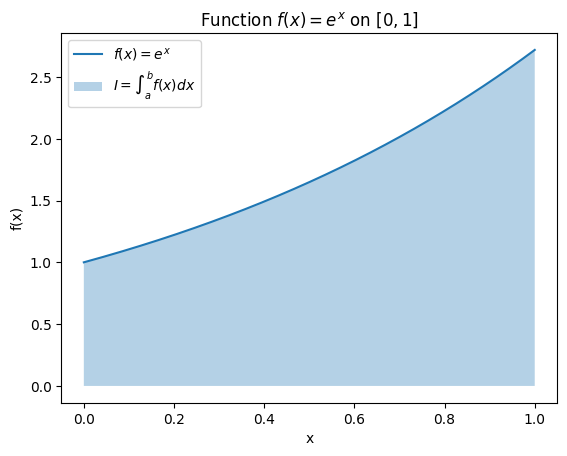

In [2]:
import matplotlib.pyplot as plt

plt.plot(X, Y, label=r"$f(x) = e^x$")
plt.fill_between(X, Y, alpha=1/3, label=r'$I = \int_a^b f(x) dx$')
plt.title(r'Function $f(x) = e^x$ on $[0,1]$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

## Riemann Sums

In undergraduate calculus, we learn the integral as the limit of
Riemann sums:
\begin{align}
  \int_a^b f(x) dx
  \equiv \lim_{n \to \infty} \sum_{i=1}^n f(x_i) \Delta x,
\end{align}
where $\Delta x \equiv (b-a)/n$.

In **numerical analysis**, however, we do **not** take the limit.
Instead, we keep the division of $[a, b]$ into $n$ subintervals and
use
\begin{align}
  I \approx \sum_{i=1}^n f(x_i)\,\Delta x,
\end{align}
as a practical approximation.
The choice of sampling point $x_i$ determines the accuracy.

Common choices for $x_i$ give us three variants:
* Left Riemann Sum: $x_i$ is the left endpoint.
* Right Riemann Sum: $x_i$ is the right endpoint.
* Midpoint (or middle) Riemann Sum: $x_i$ is the midpoint.

```{note} Analogy with Finite Differences

Just as we approximated derivatives using forward, backward, and
central differences,

Riemann sums mirror this structure:
* Left Riemann $\leftrightarrow$ forward difference
* Right Riemann $\leftrightarrow$ backward difference
* Midpoint Riemann $\leftrightarrow$ central difference

In derivatives, these approximations predict slopes.
In integrals, they approximate accumulated areas.
```

In [3]:
n  = 8  # number of intervals
dx = 1 / n

Xl = np.linspace(0, 1-dx, n)
Xm = np.linspace(dx/2, 1-dx/2, n)
Xr = np.linspace(dx, 1, n)

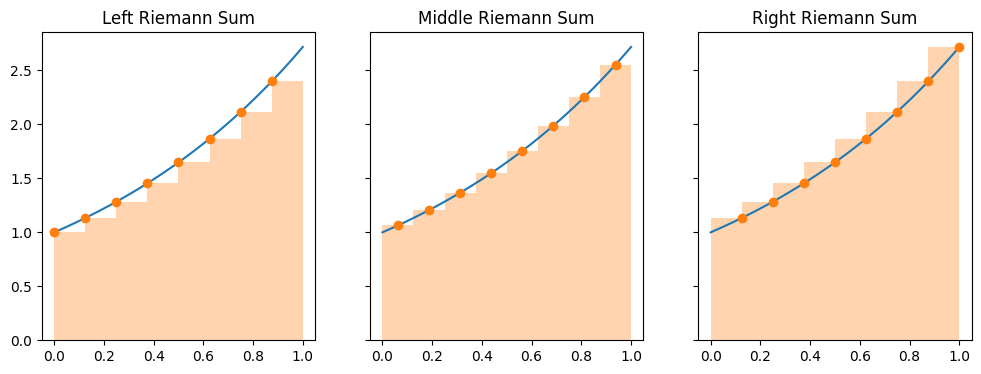

In [4]:
fig, axes = plt.subplots(1,3, figsize=(12,4), sharey=True)

# Left Riemann Sum
for ax, Xs, name in zip(axes, [Xl, Xm, Xr], ['Left', 'Middle', 'Right']):
    Ys = f(Xs)
    ax.plot(X, Y)
    ax.bar(Xm, Ys, width=dx, align='center', color='C1', edgecolor=None, alpha=1/3)
    ax.scatter(Xs, Ys, color='C1', zorder=10)
    ax.set_title(f'{name} Riemann Sum')

In [5]:
# HANDSON: There is another to define the middle Reimann sun,
#          where the sample points are "on vertex ", i.e.,
#          $x_i = a + (b-a) (i/n)$ for $i = 0, ..., n$.
#          What is the different between this definition and ours?
#          From the plots, what do you think about the relationships
#          between left, right, and this new middle Reimann sums?


### Computing Riemann Sums

Now that we have defined the left, right, and midpoint Riemann sums,
let us implement them and check their accuracy against the exact
result
\begin{align}
  I = \int_0^1 e^x \, dx = e - 1.
\end{align}

We begin with a simple case using $N=8$ subintervals.

In [6]:
I = np.e - 1

print(f"         Exact value: {I :.8f}")

for ax, Xs, name in zip(axes, [Xl, Xm, Xr], ['Left', 'Middle', 'Right']):
    S = np.sum(f(Xs)) * dx  # multiple dx after sum
    print(f"{name:>8} Riemann Sum: {S:.8f}, error = {abs(I - S):.2e}")

         Exact value: 1.71828183
    Left Riemann Sum: 1.61312598, error = 1.05e-01
  Middle Riemann Sum: 1.71716366, error = 1.12e-03
   Right Riemann Sum: 1.82791121, error = 1.10e-01


In [7]:
# HANDSON: try increasing $n$ and then observe the errors.


As the number of subintervals $n$ increases, all three Riemann sums
converge toward the exact value $e-1$.
However, the midpoint rule generally gives much better accuracy for
the same $n$, just as central differences are more accurate than
forward or backward differences.
This shows how the choice of sample points directly affects accuracy.

### Convergence of Riemann Sums

In numerical analysis, as we saw in earlier lecture, convergence means
studying how the error decreases as we refine the discretization.
For integration, we ask how does the error behave as we increase the
number of subintervals $n$?

To make comparisons easier, let's define a general function for
computing Riemann sums of any type:

In [8]:
def RiemannSum(f, n=8, a=0, b=1, method='mid'):
    dx = (b-a)/n
    hx = dx/2
    
    if method.startswith('l'):
        X = np.linspace(a,    b-dx, n)  # left endpoints
    elif method.startswith('r'):
        X = np.linspace(a+dx, b,    n)  # right endpoints
    else:
        X = np.linspace(a+hx, b-hx, n)  # midpoints
    
    return np.sum(f(X)) * dx

Now we can study convergence systematically by increasing $n$.

In [9]:
def convergence(f, N, I):
    # Compute absolute errors for each method
    El = [abs(RiemannSum(f, n, method='l') - I) for n in N]
    Em = [abs(RiemannSum(f, n, method='m') - I) for n in N]
    Er = [abs(RiemannSum(f, n, method='r') - I) for n in N]

    # Plot convergence behavior
    plt.loglog(N, El, 'o-',  label='Left Riemann Sum')
    plt.loglog(N, Em, '^--', label='Middle Riemann Sum')
    plt.loglog(N, Er, 's:',  label='Right Riemann Sum')

    # Reference slopes
    plt.loglog(N, 1.2e+0 / N,    ':', lw=1, label=r'$n^{-1}$')
    plt.loglog(N, 1.0e-1 / N**2, ':', lw=1, label=r'$n^{-2}$')

    plt.xlabel('Number of Subintervals $n$')
    plt.ylabel('Absolute Error')
    plt.title('Convergence of Riemann Sums')
    plt.legend()

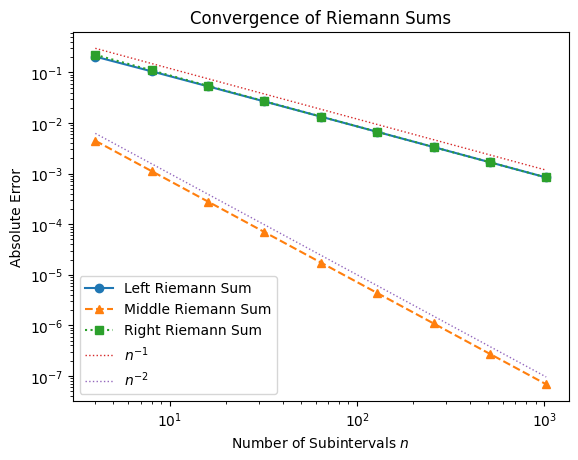

In [10]:
N = 2**np.arange(2,11)  # range of sample sizes
convergence(f, N, np.e-1)

From the plot, we observe:
* Left and Right Riemann sums converge at roughly a rate
  $\sim N^{-1}$.
* Midpoint Riemann sum converges faster, at a rate closer to
  $\sim N^{-2}$.

This higher order of accuracy explains why the midpoint method is much
more accurate for the same number of intervals.
The pattern mirrors what we saw with finite differences: forward and
backward methods are first-order accurate, while central methods are
second-order accurate.

### Testing Convergence with Different Functions

To determine if this trend holds generally, let's repeat the
convergence test with different functions:
a half-cycle of $\sin[(\pi/2)(1-x)]$ and
a quarter circle $\sqrt{1-x^2}$.

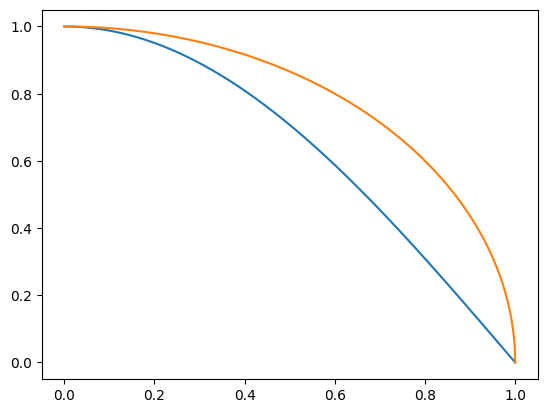

In [11]:
f2 = lambda x: np.sin((np.pi/2) * (1-x))
f3 = lambda x: np.sqrt(1 - x*x)

plt.plot(X, f2(X))
plt.plot(X, f3(X))

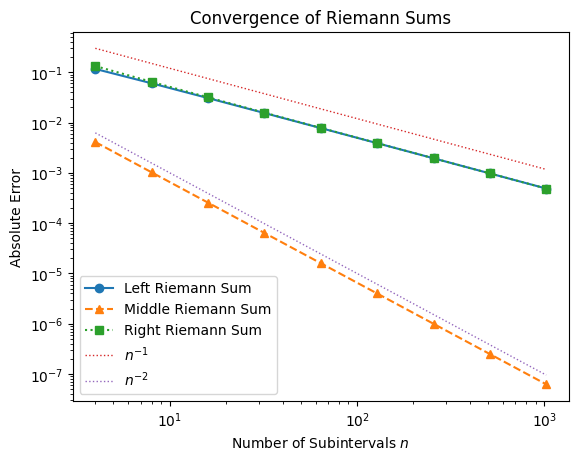

In [12]:
convergence(f2, N, 2/np.pi)

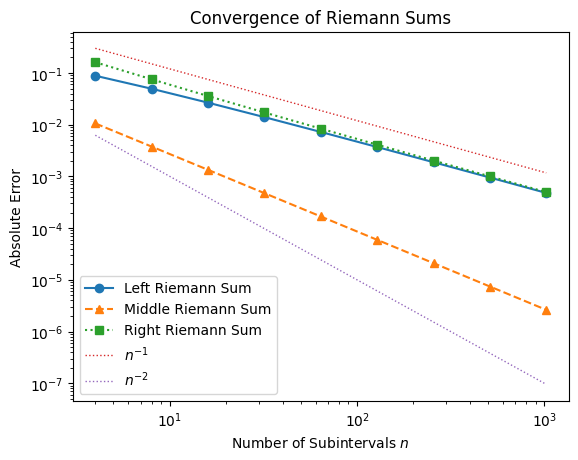

In [13]:
convergence(f3, N, np.pi/4)

In [14]:
# HANDSON: why does Middle Riemann Sum not converge as expected for
#          quarter circle?


Although the formal convergence rates hold in general, special
functions (e.g. highly oscillatory or discontinuous ones) may behave
differently.
Understanding these exceptions is a key part of numerical analysis.

As we progress, we will adopt the notation and framework used in
Numerical Recipes and related references.
These general-purpose methods extend the ideas of Riemann sums to more
accurate and flexible quadrature formulas, allowing us to tackle
realistic integration problems efficiently.

## Classical Formulas for Equally Spaced Abscissas

### Trapezoidal Rule

To move beyond Riemann sums, we now consider the trapezoidal rule, one
of the most widely used numerical integration formulas.

From here on, we adopt the vertex formulation:
\begin{align}
  x_i = a + i \Delta x,
  \quad \Delta x = \frac{b-a}{n},
  \quad i=0,1,\dots,n.
\end{align}

The trapezoidal rule approximates the area under a curve by replacing
each subinterval with a trapezoid.
For a single interval $[x_i, x_{i+1}]$ with width $h = x_{i+1} - x_i$,
we have:
\begin{align}
  \int_{x_i}^{x_{i+1}} f(x) dx
  \approx \frac{h}{2}\left[f(x_i) + f(x_{i+1})\right].
\end{align}

The error for one interval is of order $\mathcal{O}(h^3 f'')$, which
means the global error (after $n$ intervals) is $\mathcal{O}(h^2)$.
This makes the trapezoidal rule second-order accurate.
If $f(x)$ is linear (so $f''=0$), the approximation is exact.


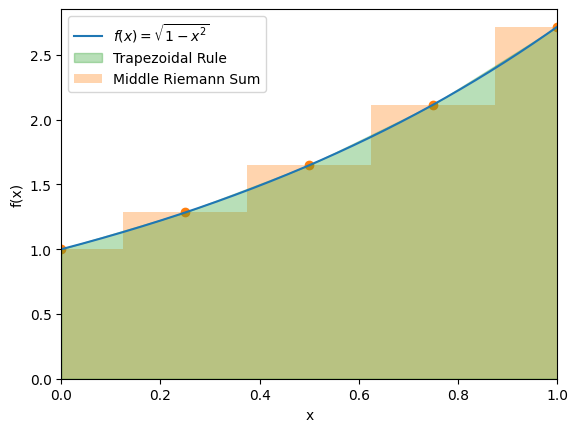

In [15]:
# Test function: quarter circle
Y = f(X)

# Plot with a coarse trapezoidal partition
n  = 4
Xt = np.linspace(0, 1, n+1)
Yt = f(Xt)

plt.plot(X, Y, label=r"$f(x) = \sqrt{1-x^2}$")
plt.scatter(Xt, Yt, color='C1')
plt.bar(Xt, Yt, width=Xt[1]-Xt[0], align='center',
        color='C1', edgecolor=None, alpha=1/3, label='Middle Riemann Sum')
plt.fill_between(Xt, Yt,
                 color='C2', alpha=1/3, label='Trapezoidal Rule')

plt.xlim(0, 1)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

In [16]:
def trapezoidal(f, n=8, a=0, b=1):
    """Trapezoidal rule integration of f from a to b using n intervals."""
    X, dx = np.linspace(a, b, n+1, retstep=True)
    return np.sum(f(X[:-1]) + f(X[1:])) * (dx/2)

In [17]:
def convergence(f, N, I):
    # Compute absolute errors for each method
    El = [abs(RiemannSum (f, n, method='l') - I) for n in N]
    Em = [abs(RiemannSum (f, n, method='m') - I) for n in N]
    Er = [abs(RiemannSum (f, n, method='r') - I) for n in N]
    Et = [abs(trapezoidal(f, n)             - I) for n in N]

    # Plot convergence behavior
    plt.loglog(N, El, 'o-',  label='Left Riemann Sum')
    plt.loglog(N, Em, '^--', label='Middle Riemann Sum')
    plt.loglog(N, Er, 's:',  label='Right Riemann Sum')
    plt.loglog(N, Et, 'x-',  label='trapezoidal')

    # Reference slopes
    plt.loglog(N, 1.2e+0 / N,    ':', lw=1, label=r'$n^{-1}$')
    plt.loglog(N, 1.0e-1 / N**2, ':', lw=1, label=r'$n^{-2}$')

    plt.xlabel('Number of Subintervals $n$')
    plt.ylabel('Absolute Error')
    plt.title('Convergence of Riemann Sums')
    plt.legend()

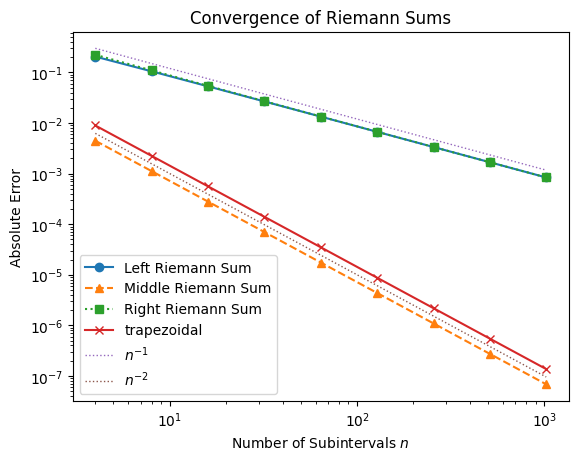

In [18]:
convergence(f, N, np.e-1)

In [19]:
# HANDSON: use trapezoidal rule to integrate a linear equation


In [20]:
# HANDSON: use trapezoidal rule to integrate a qudratic equation


In [21]:
# HANDSON: look at the figure carefully.
#          What is the result from the Middle Riemann Sum (on vertex)
#          compared to the trapezoidal rule?


In [22]:
# HANDSON: reformulate the trapezoidal rule to speed it up.


In [23]:
%timeit trapezoidal(f, n=1024)

35.6 μs ± 321 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Both the middle Riemann sum (midpoint rule) and the trapezoidal rule
achieve second-order accuracy ($\sim N^{-2}$).
In fact, the trapezoidal rule is mathematically identical to the
midpoint rule on vertices.
However, the trapezoidal rule is often preferred because it naturally
extends to more advanced methods (like Simpson's rule and Romberg
integration) and works well with non-smooth functions and tabulated
data.

### Integration vs. Differentiation

Before moving on to the next integration method, it is worth pausing
to contrast numerical integration with finite differences for
derivatives.

In finite differences, the operation is fundamentally local.
For example, once we choose a central difference formula for $f'(x)$,
the approximation uses only a fixed number of sample points (two
here).
If we want higher accuracy, we can simply reduce the step size $h$,
but the number of function evaluations per derivative remains
constant.
This means that in practice, even a low-order difference formula can
be made sufficiently accurate just by choosing a small $h$ (ignoring
round-off error for now).

Integration is different.
Approximating a definite integral requires covering the entire
interval $[a,b]$.
As we reduce $h$, we must add more sample points to span the domain.
Thus, the cost of integration scales with accuracy.
Halving $h$ would double the number of function evaluations for
first-order methods like the left or right Riemann sums.

This difference makes the order of the integration method much more
important.
* With first-order schemes (Left/Right Riemann), each refinement
  improves accuracy slowly, so many function evaluations are needed.
* With second-order schemes (Midpoint, trapezoidal), accuracy improves
  faster, but still grows in cost as $h$ decreases.
* With higher-order schemes (like Simpson's rule), we can achieve very
  accurate results with far fewer evaluations.

To summarize, for derivatives, low-order finite differences can often
be "rescued" by shrinking $h$.
For integrals, low-order methods remain inefficient no matter how
small $h$ is, because accuracy and cost is a trade-off.
This is why higher-order integration rules are so valuable.

### Simpson's Rule

The trapezoidal rule is exact for linear functions.
Naturally, we may ask: is there a method that is exact for quadratics?
This leads us to Simpson's rule, which integrates quadratic
polynomials exactly.

There are many ways to derive the Simpson's Rule.
For simplicity, let's "center" the integral at zero with limits
$[-h, h]$.
We approximate $f(x)$ by a quadratic polynomial,
\begin{align}
  f(x) \approx A x^2 + B x + C.
\end{align}

The integral becomes
\begin{align}
  \int_{-h}^h f(x) dx
  &\approx \int_{-h}^h (A x^2 + B x + C) dx \\
  &= \left[A\frac{x^3}{3} + B\frac{x^2}{2} + Cx\right]_{-h}^h \\
  &= 2h\left(\frac{A h^2}{3} + C\right).
\end{align}

To determine $A$ and $C$, we use sample points:
\begin{align}
  f(-h) &= Ah^2 - Bh + C, \\
  f( 0) &= C, \\
  f( h) &= Ah^2 + Bh + C.
\end{align}

Adding $f(-h)$ and $f(h)$ gives
\begin{align}
  f(-h) + f(h) = 2(Ah^2 + C).
\end{align}

Substituting into the integral, we obtain
\begin{align}
  \int_{-h}^h f(x) dx 
  \approx \frac{h}{3}\left[f(-h) + 4f(0) + f(h)\right].
\end{align}

Restoring general limits, Simpson's rule for an interval $[x_n, x_{n+2}]$
with midpoint $x_{n+1} = (x_0 + x_2)/2$ is
\begin{align}
  \int_{x_n}^{x_{n+1}} f(x) dx
  = \frac{h}{3}\left[f(x_0) + 4f(x_1) + f(x_2)\right] + \mathcal{O}(h^5 f^{(4)}),
\end{align}
where $h = (x_2 - x_0)/2$.

In [24]:
def SimpsonRule(f, n=8, a=0, b=1):
    """Simpson's rule integration of f from a to b using n intervals."""
    X, dx = np.linspace(a, b, n+1, retstep=True)
    S = 0
    for i in range(n//2):
        l  = X[2*i]
        m  = X[2*i + 1]
        r  = X[2*i + 2]
        S += (f(l) + 4*f(m) + f(r)) * (dx/3)
    return S

In [25]:
def convergence(f, N, I):
    # Compute absolute errors for each method
    El = [abs(RiemannSum (f, n, method='l') - I) for n in N]
    Em = [abs(RiemannSum (f, n, method='m') - I) for n in N]
    Er = [abs(RiemannSum (f, n, method='r') - I) for n in N]
    Et = [abs(trapezoidal(f, n)             - I) for n in N]
    Es = [abs(SimpsonRule(f, n)             - I) for n in N]

    # Plot convergence behavior
    plt.loglog(N, El, 'o-',  label='Left Riemann Sum')
    plt.loglog(N, Em, '^--', label='Middle Riemann Sum')
    plt.loglog(N, Er, 's:',  label='Right Riemann Sum')
    plt.loglog(N, Et, 'x-',  label='trapezoidal')
    plt.loglog(N, Es, '+-',  label="Simpson's Rule")

    # Reference slopes
    plt.loglog(N, 1.2e+0 / N,    ':', lw=1, label=r'$n^{-1}$')
    plt.loglog(N, 1.0e-1 / N**2, ':', lw=1, label=r'$n^{-2}$')
    plt.loglog(N, 1.0e-1 / N**4, ':', lw=1, label=r'$n^{-4}$')

    plt.xlabel('Number of Subintervals $n$')
    plt.ylabel('Absolute Error')
    plt.title('Convergence of Riemann Sums')
    plt.legend()

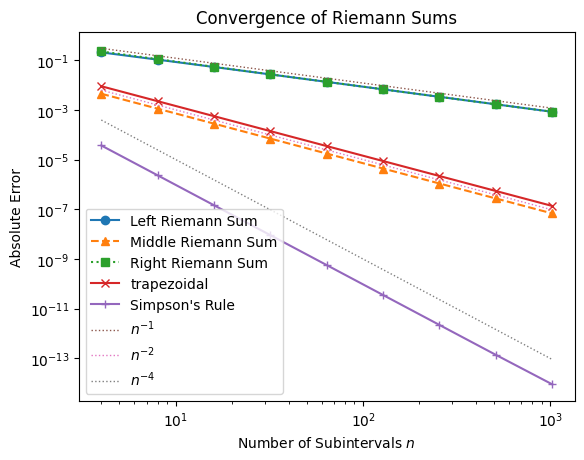

In [26]:
convergence(f, N, np.e-1)

In [27]:
# HANDSON: use Simpson's rule to integrate a quadratic equation


In [28]:
# HANDSON: use Simpson's rule to integrate a cubic equation


In [29]:
# HANDSON: use Simpson's rule to integrate a 4th-order polynomial


Simpson's rule fits a quadratic through three points, but its symmetry
makes it exact for cubics as well.
That means the first error term comes from the $h^4$ term in the
Taylor expansion, which makes it fourth-order accurate.

In [30]:
# HANDSON: reformulate the Simpson's rule to speed it up.


### Bode's Rule

Simpson's rule is exact for polynomials up to degree 3, giving
fourth-order accuracy.
If we want a rule that is exact for quartic polynomials, we can extend
the idea.
The next step in this family is Bode's rule (sometimes called the
4th-order Newton-Cotes formula).

Bode's rule uses five equally spaced points (four subintervals) and
achieves sixth-order accuracy.
The formula is:
\begin{align}
  \int_{x_0}^{x_4} f(x) dx
  = h \left[\frac{14}{45} f(x_0) + \frac{64}{45} f(x_1) + \frac{24}{45} f(x_2) + \frac{64}{45} f(x_3) + \frac{14}{45} f(x_4)\right] + \mathcal{O}(h^7 f^{(6)}),
\end{align}
where $h = (x_4 - x_0)/4$.

In [31]:
def BodeRule(f, n=8, a=0, b=1):
    """Bobe's rule integration of f from a to b using n intervals."""
    X, dx = np.linspace(a, b, n+1, retstep=True)
    S = 0
    for i in range(n//4):
        x0 = X[4*i]
        x1 = X[4*i + 1]
        x2 = X[4*i + 2]
        x3 = X[4*i + 3]
        x4 = X[4*i + 4]
        S += (14*f(x0) + 64*f(x1) + 24*f(x2) + 64*f(x3) + 14*f(x4)) * (dx/45)
    return S

In [32]:
def convergence(f, N, I):
    # Compute absolute errors for each method
    El = [abs(RiemannSum (f, n, method='l') - I) for n in N]
    Em = [abs(RiemannSum (f, n, method='m') - I) for n in N]
    Er = [abs(RiemannSum (f, n, method='r') - I) for n in N]
    Et = [abs(trapezoidal(f, n)             - I) for n in N]
    Es = [abs(SimpsonRule(f, n)             - I) for n in N]
    Eb = [abs(BodeRule   (f, n)             - I) for n in N]

    # Plot convergence behavior
    plt.loglog(N, El, 'o-',  label='Left Riemann Sum')
    plt.loglog(N, Em, '^--', label='Middle Riemann Sum')
    plt.loglog(N, Er, 's:',  label='Right Riemann Sum')
    plt.loglog(N, Et, 'x-',  label='trapezoidal')
    plt.loglog(N, Es, '+-',  label="Simpson's Rule")
    plt.loglog(N, Eb, '|-',  label="Bode's Rule")

    # Reference slopes
    plt.loglog(N, 1.2e+0 / N,    ':', lw=1, label=r'$n^{-1}$')
    plt.loglog(N, 1.0e-1 / N**2, ':', lw=1, label=r'$n^{-2}$')
    plt.loglog(N, 1.0e-1 / N**4, ':', lw=1, label=r'$n^{-4}$')
    plt.loglog(N, 1.0e-1 / N**6, ':', lw=1, label=r'$n^{-6}$')

    plt.xlabel('Number of Subintervals $n$')
    plt.ylabel('Absolute Error')
    plt.title('Convergence of Riemann Sums')
    plt.legend()

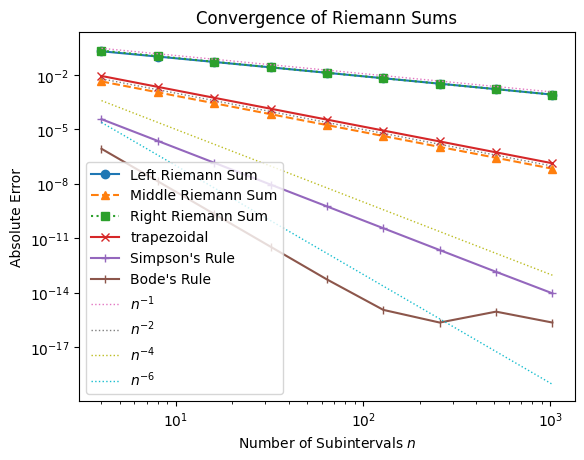

In [33]:
convergence(f, N, np.e-1)

Both Simpson's and Bode's rules are part of the Newton-Cotes family of
integration formulas.
Their main advantage is that higher-order methods achieve much greater
accuracy for the same number of function evaluations, which is
especially valuable when each evaluation is costly.
In practice, we see this in the error plots: while Simpson's rule
converges with $\mathcal{O}(h^4)$, Bode's rule converges even faster
with $\mathcal{O}(h^6)$ and eventually saturates near $10^{-15}$, the
limit of machine precision in double-precision arithmetic.

In [34]:
# HANDSON: reformulate the Bode's rule to speed it up.


## Gaussian Quadrature

So far, our integration methods (Riemann sums, trapezoidal, Simpson's,
Bode's) have all been part of the Newton–Cotes family.
These methods use equally spaced points and approximate $f(x)$ with a
polynomial that passes through them.

Gaussian quadrature takes a different approach.
Instead of fixing the points in advance, it chooses both the nodes
$x_i$ and weights $w_i$ optimally so that the approximation
\begin{align}
  I = \int_{-1}^1 f(x)\,dx \approx \sum_{i=1}^n w_i f(x_i)
\end{align}
is exact for all polynomials up to degree $2n-1$, using only $n$
evaluations!
This is far more efficient than Newton-Cotes formulas, which are exact
only up to degree $n$.

### Step 1: Exactness for Polynomials

The above approximation has $2n$ unknowns in total.
They are $n$ nodes $x_i$ and $n$ weights $w_i$.
We demand that this formula be exact for all polynomials up to degree
$2n-1$.
That means:
\begin{align}
  \int_{-1}^1 x^k dx = \sum_{i=1}^n w_i x_i^k,
  \quad \text{for } k = 0,1,\dots,2n-1.
\end{align}

This gives us $2n$ conditions. exactly enough to determine the $2n$
unknowns ($x_i$ and $w_i$).

### Step 2: Why Roots of Legendre Polynomials?

At this point, solving the nonlinear system directly would be messy.
Instead, we use a trick:
* Consider the $n$-th Legendre polynomial $P_n(x)$.
* It has $n$ distinct roots in $[-1,1]$.
* Legendre polynomials are orthogonal:
  \begin{align}
    \int_{-1}^1 P_m(x) P_n(x)\,dx = 0 \quad (m \neq n).
  \end{align}

Because of orthogonality, any polynomial of degree $\leq 2n-1$ can be
split into two parts:
1. A multiple of $P_n(x)$, which integrates to zero at the chosen
   nodes.
2. A lower-degree polynomial, which can be matched exactly by the
   quadrature formula.

This guarantees exactness up to degree $2n-1$.

### Step 3: The Weights

Once the nodes $x_i$ are fixed (the roots of $P_n(x)$), the weights
$w_i$ can be computed.
The closed form is
\begin{align}
  w_i = \frac{2}{(1 - x_i^2)\,[P_n'(x_i)]^2}.
\end{align}
This ensures the quadrature works for all polynomials of degree up to
$2n-1$.

### Step 4: Change of Interval

Gaussian quadrature is naturally defined on $[-1,1]$.
To apply it to an arbitrary interval $[a,b]$, we transform:
\begin{align}
  t = \frac{a(1-x) + b(1+x)}{2} = \frac{b-a}{2} x + \frac{b+a}{2},
  \quad dt = \frac{b-a}{2} dx,
\end{align}
which gives
\begin{align}
  \int_a^b f(t)\,dt \;\approx\; \frac{b-a}{2} \sum_{i=1}^n w_i f\!\left(\tfrac{b-a}{2}x_i + \tfrac{b+a}{2}\right).
\end{align}

In [35]:
def GQ(f, n=8, a=-1, b=1):
    """Gaussian quadrature integration of f over [a,b] using n points."""
    
    # Nodes and weights for Legendre polynomial of degree n
    X, W = np.polynomial.legendre.leggauss(n)
    
    # Map nodes from [-1,1] to [a,b]
    T = (a*(1-X) + b*(1+X))/2
    
    # Weighted sum
    return np.sum(W * f(T)) * (b-a)/2

In [36]:
def convergence(f, N, I):
    # Compute absolute errors for each method
    El = [abs(RiemannSum (f, n, method='l') - I) for n in N]
    Em = [abs(RiemannSum (f, n, method='m') - I) for n in N]
    Er = [abs(RiemannSum (f, n, method='r') - I) for n in N]
    Et = [abs(trapezoidal(f, n)             - I) for n in N]
    Es = [abs(SimpsonRule(f, n)             - I) for n in N]
    Eb = [abs(BodeRule   (f, n)             - I) for n in N]
    Eg = [abs(GQ         (f, n, 0, 1)       - I) for n in N]

    # Plot convergence behavior
    plt.loglog(N, El, 'o-',  label='Left Riemann Sum')
    plt.loglog(N, Em, '^--', label='Middle Riemann Sum')
    plt.loglog(N, Er, 's:',  label='Right Riemann Sum')
    plt.loglog(N, Et, 'x-',  label='trapezoidal')
    plt.loglog(N, Es, '+-',  label="Simpson's Rule")
    plt.loglog(N, Eb, '|-',  label="Bode's Rule")
    plt.loglog(N, Eg, '|-',  label="Gaussian Quadrature")

    # Reference slopes
    plt.loglog(N, 1.2e+0 / N,    ':', lw=1, label=r'$n^{-1}$')
    plt.loglog(N, 1.0e-1 / N**2, ':', lw=1, label=r'$n^{-2}$')
    plt.loglog(N, 1.0e-1 / N**4, ':', lw=1, label=r'$n^{-4}$')
    plt.loglog(N, 1.0e-1 / N**6, ':', lw=1, label=r'$n^{-6}$')

    plt.xlabel('Number of Subintervals $n$')
    plt.ylabel('Absolute Error')
    plt.title('Convergence of Riemann Sums')
    plt.legend(loc='right')

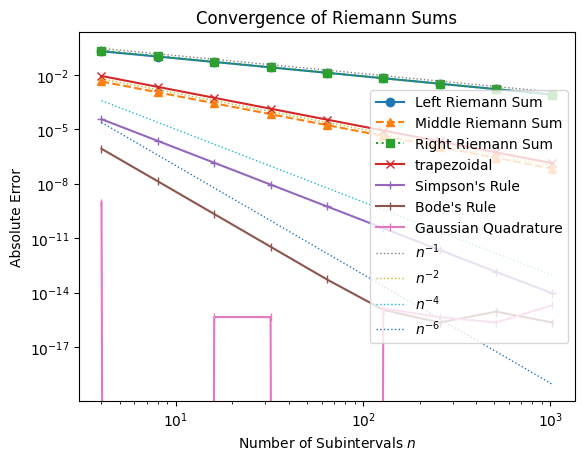

In [37]:
convergence(f, N, np.e-1)

The Gaussian quadrature method converge extremely fast.
With 8th-order approximation, its error is already less than machine
accuracy.
This makes it an ideal method to integrate smooth functions.

## Handling Improper Integrals with Coordinate Transformation

So far, we have focused on integrals over finite intervals with smooth
integrands.
But many important problems involve improper integrals, such as those
extending to infinity or with singularities at the endpoints.
Classical Newton-Cotes formulas and Gaussian quadrature cannot be
applied directly in these cases, because the domain is unbounded or
the function diverges.

As an example, consider the integral
\begin{align}
  I = \int_0^{\infty} \frac{1}{1+x^2}\,dx,
\end{align}
whose exact value is well-known $I = \pi/2$.

Standard quadrature fails here, since the domain extends to infinity.
The solution is to perform a coordinate transformation that maps the
infinite domain to a finite interval.

A common substitution is
\begin{align}
  x = \frac{t}{1-t}, \quad t \in [0,1].
\end{align}
Differentiating,
\begin{align}
  dx = \frac{dt}{(1-t)^2}.
\end{align}
Substituting into the integral gives
\begin{align}
  I = \int_0^1 \frac{1}{1+\left(\tfrac{t}{1-t}\right)^2}\,\frac{dt}{(1-t)^2}.
\end{align}
Simplifying,
\begin{align}
  I = \int_0^1 \frac{dt}{(1-t)^2 + t^2}
    = \int_0^1 \frac{dt}{1 - 2t + 2t^2}.
\end{align}

Now the infinite limit $x \to \infty$ is mapped to the finite limit $t
\to 1$.
This transformed integral can be handled efficiently using
trapezoidal, Simpson's, Bode's, or Gaussian quadrature.

In [38]:
# HANDSON: Implement the above transformed equation and integrate it
#          numerically.
#          Use `convergence()` to check its convergence property.


By carefully choosing coordinate transformations, we can extend
high-order quadrature methods to improper integrals.
This strategy will also be important for dealing with singular
integrands, where direct endpoint evaluation fails.

## Using SciPy and SymPy

In practice, you will rarely implement numerical integration formulas
(Riemann sums, trapezoidal, Simpson's, etc.) by hand in research
projects.
Instead, you will rely on well-tested libraries that provide efficient
and accurate integrators.
* SciPy offers a collection of state-of-the-art numerical integrators
  suitable for most scientific applications.
* SymPy provides tools for symbolic integration, which can return
  exact formulas when they exist.

### Numerical Integration with SciPy

The function `scipy.integrate.quad()` is a general-purpose adaptive
integrator.
It automatically refines sampling points until the estimated error is
within tolerance.

In [39]:
from scipy.integrate import quad

# Example: quarter circle integral (area of a quarter unit circle)
res, err = quad(f3, 0, 1)

print("Exact value (π/4):", np.pi/4)
print("Result:", res)
print("Estimated error:", err)

Exact value (π/4): 0.7853981633974483
Result: 0.7853981633974481
Estimated error: 8.833911380179416e-11


### Symbolic Integration with SymPy

When the integral has a closed-form expression, sympy can find it
exactly.
This is especially useful for validation, teaching, or algebraic
manipulations.

In [40]:
from sympy import Symbol, integrate, sqrt, pi

x = Symbol('x')

# Indefinite integral
expr = integrate(sqrt(1 - x**2), x)
print("Indefinite integral:", expr)

# Definite integral from 0 to 1
res = integrate(sqrt(1 - x**2), (x, 0, 1))
print("Exact value (π/4):", pi/4)
print("Definite integral:", res, "~", float(res))

Indefinite integral: x*sqrt(1 - x**2)/2 + asin(x)/2
Exact value (π/4): pi/4
Definite integral: pi/4 ~ 0.7853981633974483


In real workflows, you may combine both: use SymPy to derive formulas
where possible, and fall back on SciPy when symbolic methods fail or
when dealing with data-driven functions.

## Final Comments

* Increasing the order of approximation greatly improves accuracy.
  Higher-order methods (Simpson's, Bode's) converge much more rapidly
  than first-order rules (left/right Riemann).

* For smooth functions, methods like Gaussian quadrature achieve even
  faster, often exponential, convergence.

* Symbolic integration (e.g., with `sympy`) can provide exact results
  when closed forms exist, and serves as a useful complement to
  numerical methods.

* For non-smooth functions (with discontinuities), the convergence
  rate drops to first order, regardless of the method.
  In such cases, refining the mesh near the discontinuity is the only
  way to recover accuracy.
